<a href="https://colab.research.google.com/github/Krishna-coder6111/3d-object/blob/main/cashless2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cashless Due Bills report

Runs every wednesday after the central, west and east get uploaded. I take 30 mins to do all of the work.

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
from google.colab import drive
import glob
import openpyxl
from openpyxl.styles import PatternFill
import numpy as np
drive.mount('/content/drive')

#df = pd.read_excel('/content/drive/My Drive/reports/CP Pilot Due Bill 09-23-2023.xlsx')
#df.head()

Mounted at /content/drive


merging the files

In [ ]:
file1 = '/content/drive/My Drive/reports/West BU RSP Due Bills 09-30-23.xlsx'
file2 = '/content/drive/My Drive/reports/East BU RSP Due Bill week 09-30-23.xlsx'
file3 = '/content/drive/My Drive/reports/Central BU RSP Due Bills 09-30-2023.xlsx'

df1 = pd.read_excel(file1)
df1['Business Unit'] = 'West'

df2 = pd.read_excel(file2)
df2['Business Unit'] = 'East'

df3 = pd.read_excel(file3)
df3['Business Unit'] = 'Central'

merged_df = pd.concat([df1, df2, df3], ignore_index=True)

merged_df = merged_df[merged_df['Cashless Flag'] == 'Y']

merged_df.loc[merged_df['Sub Market'].isna(), 'Business Unit'] = np.nan

cols = ['Business Unit'] + [col for col in merged_df if col != 'Business Unit']
merged_df = merged_df[cols]

output_path = '/content/drive/My Drive/reports/CP Pilot Due Bill 09-30-2023.xlsx'
merged_df.to_excel(output_path, index=False)
print(merged_df)

      Business Unit         Sub Market Pay Lag BUSS Environment  District #  \
920            West           BMB WEST       Y               NP      2620.0   
922            West           BMB WEST       Y               NP      2620.0   
924            West           BMB WEST       Y               NP      2620.0   
928            West           BMB WEST       Y               NP      2620.0   
930            West           BMB WEST       Y               NP      2620.0   
...             ...                ...     ...              ...         ...   
17538       Central  CENTRAL NORTH BMB       Y               NL      4736.0   
17540       Central  CENTRAL NORTH BMB       Y               NL      4736.0   
17542       Central  CENTRAL NORTH BMB       Y               NL      4736.0   
17544       Central  CENTRAL NORTH BMB       Y               NL      4736.0   
17546       Central  CENTRAL NORTH BMB       Y               NL      4736.0   

          District Name  Division #     Division Na

functions to fill aging column and to add summary and totals

In [ ]:
def fill_aging(row):

    if pd.isna(row['Sub Market']):
          return np.nan

    current_date = datetime.now()
    invoice_date = pd.to_datetime(row['Invoice Date'])
    days_diff = (current_date - invoice_date).days

    if days_diff < 7:
        return 'Current'
    elif days_diff < 14:
        return 'Net 7'
    elif days_diff < 21:
        return 'Net 14'
    elif days_diff < 28:
        return 'Net 21'
    else:
        return 'Over 28'
def add_summary_and_total_due(df, sheet_name, writer):
    # Summaries
    summary = df.groupby(['Aging']).agg(
        total_customers=pd.NamedAgg(column='Customer #', aggfunc='nunique'),
        total_due=pd.NamedAgg(column='Due Bill Amount', aggfunc='sum')
    ).reset_index()

    summary.loc['Complete Total', 'total_due'] = summary['total_due'].sum()

    # Write summary and DataFrame to Excel sheet
    df.to_excel(writer, sheet_name=sheet_name, index=False, startrow=0)
    summary.to_excel(writer, sheet_name=sheet_name, index=False, startrow=df.shape[0] + 4)

def add_total_rows(df):
    # Group by 'Customer #' and aggregate relevant columns
    totals = df.groupby('Customer #').agg({
        'Sales Amount': 'sum',
        'ROA Amount': 'sum',
        'Due Bill Amount': 'sum'
    }).reset_index()

    # Add a distinguishing feature for the total rows; for instance, setting 'Business Unit' to 'TOTAL'
    totals['Customer Name'] = 'Total Due'

    # Append totals to the original dataframe
    combined_df = pd.concat([df, totals], ignore_index=True)

    # Sort by 'Customer #' and then by 'Business Unit' so that 'TOTAL' comes last for each customer
    sorted_df = combined_df.sort_values(by=['Customer #', 'Customer Name'])

    return sorted_df

original sheet = have original df + aging + summary
<br>filtered sheet = more than one delivery + positive due bill + aging + summary + total rows
<br> current sheet = same df as filtered but pop and push current into this sheet + total rows
<br> write into the sheets at the end

In [ ]:
customers_with_multiple_outstanding_invoices = '/content/drive/MyDrive/customers_with_multiple_outstanding_invoices.xlsx'

sheet_name = 'Cashless as of Week 093023'
cleaned_original_df = merged_df.copy(deep = True)
cleaned_original_df['Aging'] = cleaned_original_df.apply(fill_aging, axis=1)
cleaned_original_df_with_total = add_total_rows(cleaned_original_df)
cleaned_original_df_with_total

,Business Unit,Sub Market,Pay Lag,BUSS Environment,District #,District Name,Division #,Division Name,Sales Center #,Sale Center Name,...,Customer Name,Invoice Date,Invoice #,Sales Amount,ROA Amount,Due Bill Amount,Aging,Action Plan for Sales,Comments,Analyst
113,Central,CENTRAL NORTH BMB,Y,NL,4736.0,CHICAGO METRO EX,4788.0,ADDISON SOTH EXP,4283.0,ADDISON IL EXP,...,ALCALA CONVENIENCE,2023-09-11,52169890002504,247.12,0.0,247.12,Net 21,Collect payments,NaN,Sebastián Barragán Barrero
114,Central,CENTRAL NORTH BMB,Y,NL,4736.0,CHICAGO METRO EX,4788.0,ADDISON SOTH EXP,4283.0,ADDISON IL EXP,...,ALCALA CONVENIENCE,2023-09-18,52169890002573,154.06,0.0,154.06,Net 14,NaN,NaN,Sebastián Barragán Barrero
115,Central,CENTRAL NORTH BMB,Y,NL,4736.0,CHICAGO METRO EX,4788.0,ADDISON SOTH EXP,4283.0,ADDISON IL EXP,...,ALCALA CONVENIENCE,2023-09-25,52169890002642,360.45,0.0,360.45,Net 7,NaN,NaN,Sebastián Barragán Barrero
770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Total Due,NaT,NaN,761.63,0.0,761.63,NaN,NaN,NaN,NaN
116,Central,CENTRAL NORTH BMB,Y,NL,4736.0,CHICAGO METRO EX,1566.0,ADDISON NRTH EXP,4283.0,ADDISON IL EXP,...,LA ESTRELLA MINI MAR,2023-09-26,52383390004105,199.14,0.0,199.14,Net 7,Collect payments,NaN,Sebastián Barragán Barrero
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Total Due,NaT,NaN,462.06,0.0,462.06,NaN,NaN,NaN,NaN
769,Central,CENTRAL NORTH BMB,Y,NL,4736.0,CHICAGO METRO EX,1566.0,ADDISON NRTH EXP,4283.0,ADDISON IL EXP,...,DOLLAR BUSTER CHICAG,2023-09-29,52355790002622,278.88,0.0,278.88,Net 7,NaN,NaN,Sebastián Barragán Barrero
1254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Total Due,NaT,NaN,278.88,0.0,278.88,NaN,NaN,NaN,NaN
74,West,ROCKY MOUNTAIN,Y,DE,4002.0,ROCKY MTN NORTH,4034.0,FORT MORGAN,212.0,FT MORGAN CO RSP,...,TEMP CUST RT3987 DE,2023-08-24,85398790001632,264.60,0.0,264.60,Over 28,Collect payment,NaN,Jonathan Jiménez Retana


In [ ]:
cleaned_original_df.dtypes

Business Unit                    object
Sub Market                       object
Pay Lag                          object
BUSS Environment                 object
District #                      float64
District Name                    object
Division #                      float64
Division Name                    object
Sales Center #                  float64
Sale Center Name                 object
Route #                         float64
Route Name                       object
Cashless Flag                    object
Customer #                       object
Customer Name                    object
Invoice Date             datetime64[ns]
Invoice #                        object
Sales Amount                    float64
ROA Amount                      float64
Due Bill Amount                 float64
Aging                            object
Action Plan for Sales            object
Comments                         object
Analyst                          object
dtype: object

In [ ]:
summary = cleaned_original_df.groupby(['Aging']).agg(
        total_customers=pd.NamedAgg(column='Customer #', aggfunc='nunique'),
        total_due=pd.NamedAgg(column='Due Bill Amount', aggfunc='sum')
    ).reset_index()
summary

,Aging,total_customers,total_due
0,Current,6,1638.36
1,Net 14,176,32853.08
2,Net 21,147,23753.66
3,Net 7,342,72988.93
4,Over 28,17,3465.15


filtered sheet

In [ ]:
grouped = cleaned_original_df[cleaned_original_df['Due Bill Amount'] > 0].groupby('Customer #').filter(lambda x: len(x) > 1)

# Filter the original dataframe to include only rows that match the above condition and have 'Cashless Flag' set to 'Y'
filtered_df = cleaned_original_df[(cleaned_original_df['Customer #'].isin(grouped['Customer #'])) & (cleaned_original_df['Cashless Flag'] == 'Y')]
filtered_df_with_total = add_total_rows(filtered_df)
filtered_df_with_total

,Business Unit,Sub Market,Pay Lag,BUSS Environment,District #,District Name,Division #,Division Name,Sales Center #,Sale Center Name,...,Customer Name,Invoice Date,Invoice #,Sales Amount,ROA Amount,Due Bill Amount,Aging,Action Plan for Sales,Comments,Analyst
49,Central,CENTRAL NORTH BMB,Y,NL,4736.0,CHICAGO METRO EX,4788.0,ADDISON SOTH EXP,4283.0,ADDISON IL EXP,...,ALCALA CONVENIENCE,2023-09-11,52169890002504,247.12,0.0,247.12,Net 21,Collect payments,NaN,Sebastián Barragán Barrero
50,Central,CENTRAL NORTH BMB,Y,NL,4736.0,CHICAGO METRO EX,4788.0,ADDISON SOTH EXP,4283.0,ADDISON IL EXP,...,ALCALA CONVENIENCE,2023-09-18,52169890002573,154.06,0.0,154.06,Net 14,NaN,NaN,Sebastián Barragán Barrero
51,Central,CENTRAL NORTH BMB,Y,NL,4736.0,CHICAGO METRO EX,4788.0,ADDISON SOTH EXP,4283.0,ADDISON IL EXP,...,ALCALA CONVENIENCE,2023-09-25,52169890002642,360.45,0.0,360.45,Net 7,NaN,NaN,Sebastián Barragán Barrero
431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Total Due,NaT,NaN,761.63,0.0,761.63,NaN,NaN,NaN,NaN
52,Central,CENTRAL NORTH BMB,Y,NL,4736.0,CHICAGO METRO EX,4788.0,ADDISON SOTH EXP,4283.0,ADDISON IL EXP,...,CITGO 0862,2023-09-11,52039390003445,24.31,0.0,24.31,Net 21,NaN,10/3: Need to investigate > Overage -$31.24 - ...,Sebastián Barragán Barrero
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,Central,CENTRAL NORTH BMB,Y,NL,4736.0,CHICAGO METRO EX,1566.0,ADDISON NRTH EXP,4283.0,ADDISON IL EXP,...,SHELL GAS NORTH AVE,2023-09-27,52383290003137,82.99,0.0,82.99,Net 7,NaN,NaN,Sebastián Barragán Barrero
578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Total Due,NaT,NaN,336.17,0.0,336.17,NaN,NaN,NaN,NaN
429,Central,CENTRAL NORTH BMB,Y,NL,4736.0,CHICAGO METRO EX,1566.0,ADDISON NRTH EXP,4283.0,ADDISON IL EXP,...,CITGO GAS RIDGELAND,2023-09-14,52039990003938,100.37,0.0,100.37,Net 21,Collect payments,NaN,Sebastián Barragán Barrero
430,Central,CENTRAL NORTH BMB,Y,NL,4736.0,CHICAGO METRO EX,1566.0,ADDISON NRTH EXP,4283.0,ADDISON IL EXP,...,CITGO GAS RIDGELAND,2023-09-28,52039990004081,266.54,0.0,266.54,Net 7,NaN,NaN,Sebastián Barragán Barrero


current sheet

In [ ]:
current_df = filtered_df[filtered_df['Aging'] == 'Current']
current_df_with_total = add_total_rows(current_df)
current_df_with_total

,Business Unit,Sub Market,Pay Lag,BUSS Environment,District #,District Name,Division #,Division Name,Sales Center #,Sale Center Name,...,Customer Name,Invoice Date,Invoice #,Sales Amount,ROA Amount,Due Bill Amount,Aging,Action Plan for Sales,Comments,Analyst
0,West,ROCKY MOUNTAIN,Y,DE,4002.0,ROCKY MTN NORTH,4034.0,FORT MORGAN,212.0,FT MORGAN CO RSP,...,MIDWEST GAS GROCERY,2023-09-30,85327990002327,155.92,0.0,155.92,Current,NaN,NaN,Jonathan Jiménez Retana
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Total Due,NaT,NaN,155.92,0.0,155.92,NaN,NaN,NaN,NaN


writing into the files

In [ ]:
with pd.ExcelWriter(customers_with_multiple_outstanding_invoices) as writer:
  add_summary_and_total_due(cleaned_original_df_with_total, f'Original_{sheet_name}', writer)
  add_summary_and_total_due(filtered_df_with_total, f'Multiple Outstanding Deliveries', writer)
  #add_summary_and_total_due(current_df_with_total, f'Current_{sheet_name}', writer)

/usr/local/lib/python3.10/dist-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


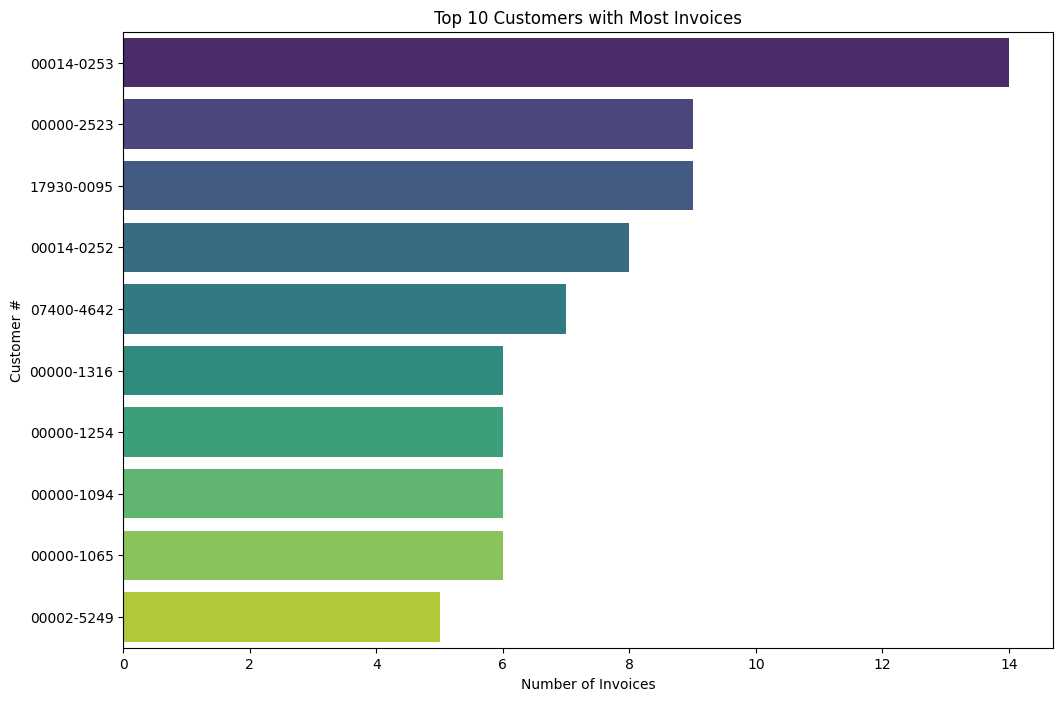

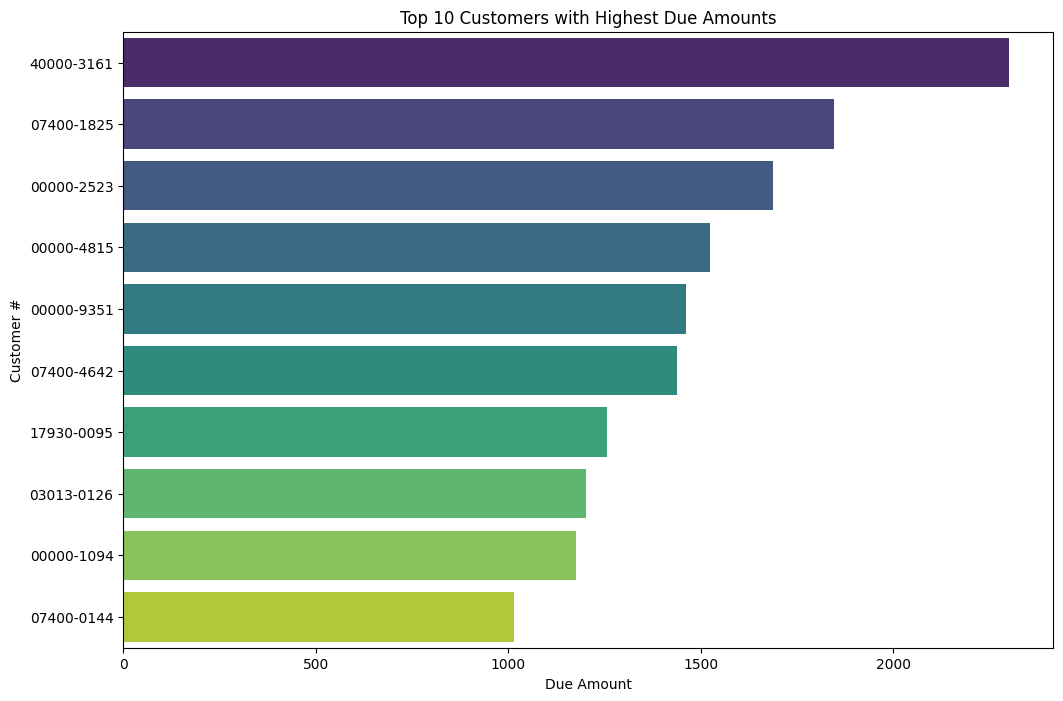

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'Customer #' and count the invoices
invoice_counts = filtered_df.groupby('Customer #')['Invoice #'].nunique().reset_index()

# Sort the data to get the top customers with the most invoices
top_customers = invoice_counts.sort_values(by='Invoice #', ascending=False).head(10)

# Plot the data
plt.figure(figsize=(12, 8))
sns.barplot(x='Invoice #', y='Customer #', data=top_customers, palette='viridis')
plt.title('Top 10 Customers with Most Invoices - Filtered Sheet')
plt.xlabel('Number of Invoices')
plt.ylabel('Customer #')
plt.show()

# Group by 'Customer #' and sum the due amounts
due_amounts = merged_df.groupby('Customer #')['Due Bill Amount'].sum().reset_index()

# Sort the data to get the top customers with the most due amounts
top_due_customers = due_amounts.sort_values(by='Due Bill Amount', ascending=False).head(10)

# Plot the data
plt.figure(figsize=(12, 8))
sns.barplot(x='Due Bill Amount', y='Customer #', data=top_due_customers, palette='viridis')
plt.title('Top 10 Customers with Highest Due Amounts - Original Sheet')
plt.xlabel('Due Amount')
plt.ylabel('Customer #')
plt.show()

convert everything into table, double check the totals, file name should be Cashless Due Bills {Date}

#look for a way to automate

In [ ]:
#